In [1]:
from models import TSP, CompleteGraph, HopfieldNetwork
import numpy as np
from scipy.linalg import circulant

In [2]:
class TemporalGraph: #dummy class
    def __init__(self, G_list):
        pass
    def __init__(self, n):
        self.n = n
        graphs = [CompleteGraph(n)]
        self.adj = graphs[-1].get_adj()
        for i in range(1,n):
            graphs.append(CompleteGraph(n))
            new_adj = graphs[-1].get_adj()
            self.adj = np.hstack([self.adj, new_adj])
        self.graphs = graphs
    def draw_graphs(self):
        for g in self.graphs:
            g.draw_graph()

In [6]:
class TDTSP(TSP):
    def __init__(self, temporal_graph, A=500, B=500, C=200, D=1):
        self.adj = temporal_graph.adj
        self.n = temporal_graph.n
        self.I = 2*C * (self.n) * np.ones(self.n**2)
        self.A = A
        self.B = B
        self.C = C
        self.D = 2*D
        self.offset = C * self.n**2
        self.T = self.compute_T()
    def selector(self, i):
        result = np.zeros((self.n, self.n))
        result[i,i] = 1
        return result
    def get_commuter(self, size, idx):
        result = np.zeros(size)
        result[idx] = 1
        return circulant(result).T
    def compute_K(self):
        selector = self.selector(0)
        P_1 = self.get_commuter(self.n,1)
        P_2 = self.get_commuter((self.n)**2, -self.n)
        A = self.adj.copy()
        K = np.kron(self.adj, selector)
        for i in range(1,self.n):
            selector = P_1.T@selector@P_1
            A = A@P_2
            K += np.kron(A, selector)
        return K[:self.n**2, :self.n**2]
    
    def compute_T(self):
        Id = np.eye(self.n)
        J = 1-Id
        M1 = np.kron(Id, J)
        Phi = self.commutation_matrix(self.n)
        M2 = Phi.T@(M1@Phi)
        alpha_matrix = self.circulant_matrix()
        
        
        K = self.compute_K()
        P = self.get_commuter(self.n, -1).T
        print(P)
        M3 = K@(np.kron(Id, P))
        M4 = np.ones((self.n**2, self.n**2))
        T = -self.A*M1 -self.B*M2 -self.C*2*M4 - self.D*M3
        return (M1, M2, M3, self.C*2*M4, T, self.C)

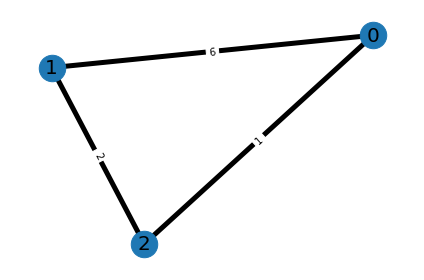

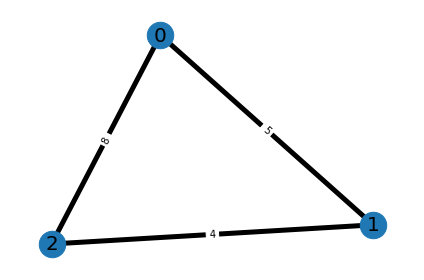

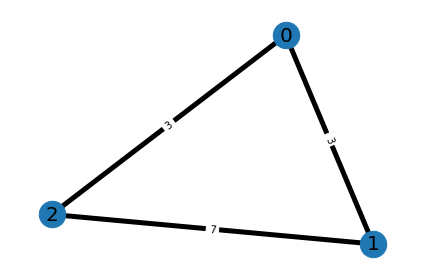

In [7]:
tg = TemporalGraph(3)
tg.draw_graphs()

In [8]:
tsp = TDTSP(tg,A=-500, B=-500, C=-200, D=-1)

[[0 6 1 0 5 8 0 3 3]
 [6 0 2 5 0 4 3 0 7]
 [1 2 0 8 4 0 3 7 0]]
[[0. 0. 0. 6. 0. 0. 1. 0. 0. 0. 0. 0. 5. 0. 0. 8. 0. 0. 0. 0. 0. 3. 0. 0.
  3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [6. 0. 0. 0. 0. 0. 2. 0. 0. 5. 0. 0. 0. 0. 0. 4. 0. 0. 3. 0. 0. 0. 0. 0.
  7. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [1. 0. 0. 2. 0. 0. 0. 0. 0. 8. 0. 0. 4. 0. 0. 0. 0. 0. 3. 0. 0. 7. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0.]]
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [24]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [25]:
qubo = tsp.to_qubo()
print(qubo.prettyprint())

exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
sol = exact.solve(qubo)
print(sol)
print(tsp.interpret(sol.x))

Problem name: 

Minimize
  200*x0^2 + 900*x0*x1 + 400*x0*x10 + 848*x0*x11 + 900*x0*x12 + 1228*x0*x13
  + 400*x0*x14 + 672*x0*x15 + 900*x0*x2 + 900*x0*x3 + 900*x0*x4 + 1041*x0*x5
  + 400*x0*x6 + 699*x0*x7 + 900*x0*x8 + 1190*x0*x9 + 200*x1^2 + 460*x1*x10
  + 400*x1*x11 + 1228*x1*x12 + 900*x1*x13 + 1057*x1*x14 + 400*x1*x15 + 900*x1*x2
  + 900*x1*x3 + 1041*x1*x4 + 900*x1*x5 + 934*x1*x6 + 400*x1*x7 + 1190*x1*x8
  + 900*x1*x9 + 200*x10^2 + 900*x10*x11 + 400*x10*x12 + 1366*x10*x13
  + 900*x10*x14 + 816*x10*x15 + 200*x11^2 + 764*x11*x12 + 400*x11*x13
  + 816*x11*x14 + 900*x11*x15 + 200*x12^2 + 900*x12*x13 + 900*x12*x14
  + 900*x12*x15 + 200*x13^2 + 900*x13*x14 + 900*x13*x15 + 200*x14^2
  + 900*x14*x15 + 200*x15^2 + 900*x2*x10 + 974*x2*x11 + 400*x2*x12 + 1057*x2*x13
  + 900*x2*x14 + 1247*x2*x15 + 200*x2^2 + 900*x2*x3 + 400*x2*x4 + 934*x2*x5
  + 900*x2*x6 + 1313*x2*x7 + 400*x2*x8 + 460*x2*x9 + 974*x3*x10 + 900*x3*x11
  + 672*x3*x12 + 400*x3*x13 + 1247*x3*x14 + 900*x3*x15 + 200*x3^2 + 699*x3*x4
 

In [17]:
# Encode Qubo formulation into Ising Model Hamiltonian
H, offset = qubo.to_ising()

In [9]:
# Solve on Ising model using NumPyMinimumEigensolver
algorithm_globals.random_seed = 10598
exact_mes = NumPyMinimumEigensolver()

In [10]:
exact = MinimumEigenOptimizer(exact_mes)  # using the exact classical numpy minimum eigen solver

In [11]:
exact_result = exact.solve(qubo)
print(exact_result.prettyprint())

solution = exact_result.x

tsp.interpret(solution)

objective function value: 500.0
variable values: x0=1.0, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0, x6=0.0, x7=0.0, x8=0.0, x9=0.0, x10=0.0, x11=1.0, x12=0.0, x13=0.0, x14=1.0, x15=0.0
status: SUCCESS


array([0., 0., 3., 2.])